In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as mx
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split,KFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report,RocCurveDisplay,auc
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR, NuSVR, LinearSVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.preprocessing import scale 

from numpy import mean, std

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.inspection import permutation_importance


In [2]:
circRNA_HCC=pd.read_table('HCC_circRNAs.txt').T
circRNA_HCC.columns=circRNA_HCC.iloc[0]
circRNA_HCC=circRNA_HCC.iloc[1:,:]

circRNA_Healthy=pd.read_table('Healthy_circRNAs.txt').T
circRNA_Healthy.columns=circRNA_Healthy.iloc[0]
circRNA_Healthy=circRNA_Healthy.iloc[1:,:]


circRNA=pd.concat([circRNA_HCC,circRNA_Healthy],axis=0)

longRNA_HCC=pd.read_table('HCC_longRNAs.txt').T
longRNA_HCC.columns=longRNA_HCC.iloc[0]
longRNA_HCC=longRNA_HCC.iloc[1:,:]

longRNA_Healthy=pd.read_table('Healthy_longRNAs.txt').T
longRNA_Healthy.columns=longRNA_Healthy.iloc[0]
longRNA_Healthy=longRNA_Healthy.iloc[1:,:]

longRNA_HCC['Group']='1'
longRNA_Healthy['Group']='0'
longRNA=pd.concat([longRNA_HCC,longRNA_Healthy],axis=0)

full_data=pd.concat([circRNA,longRNA], axis=1, ignore_index=True)
full_data.columns=circRNA.columns.append(longRNA.columns)


In [3]:
print(circRNA.shape)
print(longRNA.shape)
print(full_data.shape)


(230, 79084)
(230, 35518)
(230, 114602)


In [4]:
Y=full_data.iloc[:,full_data.columns == 'Group']
X=full_data.iloc[:,full_data.columns != 'Group']

In [5]:
from sklearn.model_selection import train_test_split

# Split the df into 80% train 20% test data; then further split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20, random_state=1303,stratify=Y, shuffle = True)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size= 0.20, random_state=1303,stratify=Y_train,shuffle = True)

In [7]:
print(Y_train[(Y_train=='0')].count())
print(len(Y_train))
print(Y_val[(Y_val=='0')].count())
print(len(Y_val))
print(Y_test[(Y_test=='0')].count())
len(Y_test)

Group    94
dtype: int64
184
Group    19
dtype: int64
37
Group    24
dtype: int64


46

In [5]:
X_tr=X_tr.replace(0.0, np.nan)
perc = 80.0
min_count =  int(((100-perc)/100)*X_tr.shape[0] + 1)
Xtr_filtered = X_tr.dropna( axis=1, 
                thresh=min_count)

In [6]:
filtered_features= X_val.columns.intersection(Xtr_filtered.columns)
Xval_filtered=X_val[filtered_features]

In [7]:
Xtr_filtered=Xtr_filtered.fillna(0)
Xval_filtered=Xval_filtered.fillna(0)

In [ ]:
Xtr_filtered.iloc[:,Xtr_filtered.columns.str.startswith('exo_circ')]

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(Xtr_filtered['exo_circ_29616'], bins=50)

In [8]:

from sklearn.preprocessing import Normalizer
transformer = Normalizer()
Xtr_filtered_S=transformer.fit_transform(Xtr_filtered)
Xval_filtered_S=transformer.transform(Xval_filtered)



In [ ]:
forplotting=pd.DataFrame(Xtr_filtered_S)
forplotting.columns=np.array(Xtr_filtered.columns)
forplotting

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(forplotting['exo_circ_29616'], bins=50)

In [ ]:

corretn_matrx = forplotting.corr()
# Print the correlation matrix.
print(corretn_matrx)
# Pass the above correlation matrix and annot = True as the arguments to the heatmap() function 
# to visualize the above correlation matrix


In [ ]:

[(i, j) for i,j in zip(*np.where(np.abs(corretn_matrx.values) >0.99)) if i!=j]


In [9]:
param_grid_SVC = {'C': np.logspace(-2, 10, 13), 
              'random_state':[1303],
              'kernel':['linear','poly','rbf','sigmoid'],
              'gamma':['scale','auto']}

gridcv = GridSearchCV(SVC(), param_grid_SVC, refit=True, cv=5, verbose=1, n_jobs=-1)


# fit the model for grid search 
gridcv.fit(Xtr_filtered_S, Y_tr) 
 
# display best parameters after tuning 
display(gridcv.best_params_) 
gridcv_pred = gridcv.predict(Xval_filtered_S) 
   
# classification report 
print(classification_report(Y_val, gridcv_pred))

Fitting 5 folds for each of 104 candidates, totalling 520 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10.0, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 1303}

              precision    recall  f1-score   support

           0       0.93      0.68      0.79        19
           1       0.74      0.94      0.83        18

    accuracy                           0.81        37
   macro avg       0.83      0.81      0.81        37
weighted avg       0.84      0.81      0.81        37



C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8108108108108109

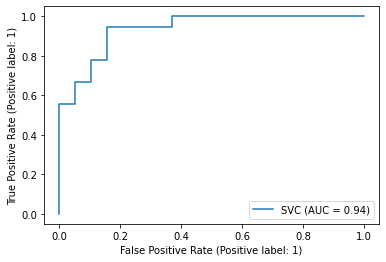

In [14]:
clfSVC = SVC(
    C=10, 
    kernel='poly', 
    random_state = 1303,
    gamma = 'scale'
)

model=clfSVC.fit(Xtr_filtered_S, Y_tr)
y_pred_svc = model.predict(Xval_filtered_S)
accuracy = accuracy_score(Y_val, y_pred_svc)
display(accuracy)
RocCurveDisplay.from_estimator(model,Xval_filtered_S,Y_val)
plt.show()

In [15]:
Y_tr=np.array(Y_tr)
Y_tr=Y_tr.flatten()
r = permutation_importance(clfSVC.fit(Xtr_filtered_S, Y_tr),Xval_filtered_S, Y_val, n_repeats=3, random_state=1303)


In [16]:
features_SVM = pd.DataFrame(columns = ['RNA', 'mean_imp', 'mean_std'])


for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0:
        features_SVM = pd.concat([features_SVM, pd.DataFrame(
            [{'RNA': Xtr_filtered.columns[i], 
              'mean_imp': r.importances_mean[i], 
              'mean_std':r.importances_std[i]}])],ignore_index=True)     
features_SVM

,RNA,mean_imp,mean_std
0,MTRNR2L8,0.162162,0.079565
1,FTL,0.09009,0.033709
2,exo_circ_22106,0.036036,0.033709
3,PPBP,0.027027,0.022067
4,TMSB4X,0.018018,0.025481
5,S100A11,0.018018,0.050963
6,S100A9,0.009009,0.012741
7,ACTB,0.009009,0.012741
8,exo_circ_79050,0.0,0.022067


In [17]:
x=pd.DataFrame(features_SVM['RNA'])
x.style.hide_index()
features_SVM['mean_imp'][8]

C:\Users\e0998126.NUSSTU\AppData\Local\Temp\ipykernel_22464\3963758626.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  x.style.hide_index()


3.700743415417188e-17

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([8], dtype=int64),)


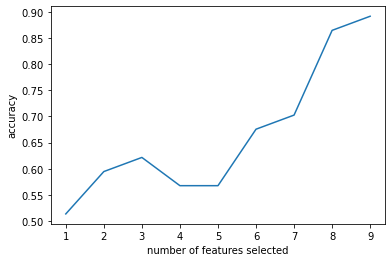

In [18]:
def optimal_features (features):
    Xtr_SVM=Xtr_filtered.filter(features)
    Xval_SVM=Xval_filtered.filter(features)
    XtrSVM_S = transformer.fit_transform(Xtr_SVM)
    XvalSVM_S = transformer.fit_transform(Xval_SVM)
    model_SVM=clfSVC.fit(XtrSVM_S, Y_tr)
    Ypred_SVM = model_SVM.predict(XvalSVM_S)
    return(accuracy_score(Y_val, Ypred_SVM)) 

accuracy =[]
for i in range(1, 10) :
    accuracy.append(optimal_features(features_SVM['RNA'][:i]))
   
    
sns.lineplot(range(1,10),accuracy,)
plt.xlabel('number of features selected')
plt.ylabel('accuracy')    

print(np.where(accuracy==np.max(accuracy)))

0.8918918918918919


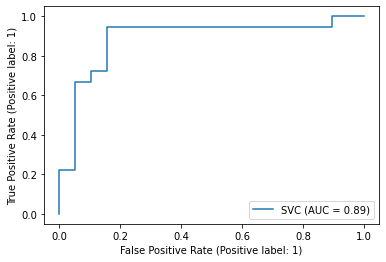

In [19]:
Xtr_SVM=Xtr_filtered.filter(features_SVM['RNA'][:9])
Xval_SVM=Xval_filtered.filter(features_SVM['RNA'][:9])
XtrSVM_S = transformer.fit_transform(Xtr_SVM)
XvalSVM_S = transformer.fit_transform(Xval_SVM)
model_SVM=clfSVC.fit(XtrSVM_S, Y_tr)
Ypred_SVM = model_SVM.predict(XvalSVM_S)
print(accuracy_score(Y_val, Ypred_SVM))
RocCurveDisplay.from_estimator(model_SVM,XvalSVM_S,Y_val)
plt.show()

In [20]:
cmat = confusion_matrix(Y_val, Ypred_SVM)
printPerformance(cmat)

NameError: name 'printPerformance' is not defined

In [ ]:
n_estimators = [ 200, 1000, 7000]
max_depth = [5, 8]
min_samples_split = [2, 5, 15]
min_samples_leaf = [1, 2, 5] 
class_weight=['balanced_subsample']
parameters = dict(n_estimators = n_estimators, max_depth = max_depth,min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,class_weight=class_weight)

gridF = GridSearchCV(RandomForestClassifier(random_state = 1303), parameters, cv = 5, verbose = 1, n_jobs = -1)
bestF = gridF.fit(Xtr_filtered_S, Y_tr)
display(bestF.best_params_) 
bestF_pred = bestF.predict(Xval_filtered_S)

print(classification_report(Y_val, bestF_pred))
print('accuracy:', accuracy_score(Y_val, bestF_pred))

In [ ]:
bestF = RandomForestClassifier(
    n_estimators=1000, 
    criterion='gini', 
    oob_score=True, 
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split= 2,
    class_weight='balanced_subsample',
    random_state=1303)
y_pred = bestF.fit(Xtr_filtered_S, Y_tr).predict(Xval_filtered_S)
print(classification_report(Y_val, y_pred))
print('accuracy:', accuracy_score(Y_val, y_pred))
RocCurveDisplay.from_estimator(bestF,Xval_filtered_S,Y_val)
plt.show()

In [ ]:
s = permutation_importance(bestF.fit(Xtr_filtered_S, Y_tr),Xval_filtered_S, Y_val, n_repeats=3, random_state=1303)

In [ ]:
features_RF = pd.DataFrame(columns = ['RNA', 'mean_imp', 'mean_std'])


for i in s.importances_mean.argsort()[::-1]:
    if s.importances_mean[i] > 0:
        features_RF = pd.concat([features_RF, pd.DataFrame(
            [{'RNA': Xtr_filtered.columns[i], 
              'mean_imp': s.importances_mean[i], 
              'mean_std':s.importances_std[i]}])],ignore_index=True)     

In [ ]:
features_RF


In [ ]:
def optimal_features_RF (features_RF):
    Xtr_RF=Xtr_filtered.filter(features_RF)
    Xval_RF=Xval_filtered.filter(features_RF)
    XtrRF_S = transformer.fit_transform(Xtr_RF)
    XvalRF_S = transformer.fit_transform(Xval_RF)
    model_RF=bestF.fit(XtrRF_S, Y_tr)
    Ypred_RF = model_RF.predict(XvalRF_S)
    return(accuracy_score(Y_val, Ypred_RF)) 
    

In [ ]:
accuracy =[]
for i in range(1, len(features_RF['RNA'])) :
    accuracy.append(optimal_features_RF(features_RF['RNA'][:i]))
    
sns.lineplot(range(1,len(features_RF['RNA'])),accuracy,)
plt.xlabel('number of features selected')
plt.ylabel('accuracy')

In [ ]:
np.where(accuracy==np.max(accuracy))

In [ ]:
Xtr_RF=Xtr_filtered.filter(features_RF['RNA'][:13])
Xval_RF=Xval_filtered.filter(features_RF['RNA'][:13])
XtrRF_S = transformer.fit_transform(Xtr_RF)
XvalRF_S = transformer.fit_transform(Xval_RF)
model_RF=bestF.fit(XtrRF_S, Y_tr)
Ypred_RF = model_RF.predict(XvalRF_S)
print(accuracy_score(Y_val, Ypred_RF))
RocCurveDisplay.from_estimator(model_RF,XvalRF_S,Y_val)
plt.show()

In [ ]:
features_RF[features_RF['RNA'].isin(features_SVM['RNA'])]


In [ ]:
Xtr_filtered.shape

In [ ]:
rfecv = RFECV(
    estimator=bestF,
    step = 150,
    cv = 3,
    scoring = "accuracy",
    min_features_to_select=1,)
   
%time rfecv.fit(Xtr_filtered_S, Y_tr)
#display('optimal n of features: %d'% rfecv.n_features_)
display(rfecv)

In [ ]:
len(rfecv.grid_scores_)

In [ ]:
plt.xlabel("number of features selected")
plt.ylabel("accuracy")
sns.lineplot(range(1,102), rfecv.grid_scores_,)

In [ ]:
optim_features_RF = rfecv.support_
feature_indeces = []
for i, feat in enumerate(optim_features_RF):
    if feat == True:
        feature_indeces.append(i)
        
Xtr_filtered.iloc[:,feature_indeces ]

In [ ]:
Xtr_RF=Xtr_filtered.filter(Xtr_filtered.iloc[:,feature_indeces])
Xval_RF=Xval_filtered.filter(Xtr_filtered.iloc[:,feature_indeces])
XtrRF_S = transformer.fit_transform(Xtr_RF)
XvalRF_S = transformer.fit_transform(Xval_RF)
model_RF=bestF.fit(XtrRF_S, Y_tr)
Ypred_RF = model_RF.predict(XvalRF_S)
print(accuracy_score(Y_val, Ypred_RF))
RocCurveDisplay.from_estimator(model_RF,XvalRF_S,Y_val)
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier 
def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

In [ ]:
parameters = {'solver': ['lbfgs','adam','sgd'], 'max_iter': [200], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':[(100,200)] ,'random_state':[1303], 'activation':['tanh','relu','logistic']}
mlp = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
mlp.fit(Xtr_filtered_S, Y_tr)

y_predmlp = mlp.predict(Xval_filtered_S)
cmat = confusion_matrix(Y_val, y_predmlp)
printPerformance(cmat)
print(mlp.best_params_)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (100,200,200,100), 
                   activation = 'relu', 
                   solver = 'lbfgs', 
                   learning_rate_init = 0.005,
                   learning_rate = 'constant',
                   max_iter = 200,
                   verbose = False,
                   random_state = 1303,
                   alpha = 1e-06)
mlp.fit(Xtr_filtered_S, Y_tr)
y_pred=mlp.predict(Xval_filtered_S)
cmat = confusion_matrix(Y_val, y_pred)
printPerformance(cmat)
print(accuracy_score(Y_val, y_pred))
RocCurveDisplay.from_estimator(mlp.fit(Xtr_filtered_S, Y_tr),Xval_filtered_S,Y_val)
plt.show()

In [ ]:
t = permutation_importance(mlp.fit(Xtr_filtered_S, Y_tr), Xval_filtered_S, Y_val, n_repeats=3, random_state=1303)


In [ ]:
features_mlp = pd.DataFrame(columns = ['RNA', 'mean_imp', 'mean_std'])



for i in t.importances_mean.argsort()[::-1]:
    if t.importances_mean[i]> 0:
        features_mlp = pd.concat([features_mlp, pd.DataFrame(
            [{'RNA': Xtr_filtered.columns[i], 
              'mean_imp': t.importances_mean[i], 
              'mean_std':t.importances_std[i]}])],ignore_index=True)     
        


features_mlp

In [ ]:
pd.DataFrame(features_mlp['mean_std'].iloc[:27]).style.hide(axis='index')

In [ ]:
def optimal_features_mlp (features_mlp):
    Xtr_mlp=Xtr_filtered.filter(features_mlp)
    Xval_mlp=Xval_filtered.filter(features_mlp)
    Xtrmlp_S = transformer.fit_transform(Xtr_mlp)
    Xvalmlp_S = transformer.fit_transform(Xval_mlp)
    model_mlp=mlp.fit(Xtrmlp_S, Y_tr)
    Ypred_mlp = model_mlp.predict(Xvalmlp_S)
    return(accuracy_score(Y_val, Ypred_mlp)) 

accuracy =[]
for i in range(1, len(features_mlp['RNA'])) :
    accuracy.append(optimal_features_mlp(features_mlp['RNA'][:i]))
    
sns.lineplot(range(1,len(features_mlp['RNA'])),accuracy,)
plt.xlabel('number of features selected')
plt.ylabel('accuracy')
np.where(accuracy==np.max(accuracy))

In [ ]:
sns.lineplot(range(15,len(features_mlp['RNA'])),accuracy,)
plt.xlabel('number of features selected')
plt.ylabel('accuracy')

In [ ]:
np.where(accuracy==np.max(accuracy))

In [ ]:
Xtr_mlp=Xtr_filtered.filter(features_mlp['RNA'][:99])
Xval_mlp=Xval_filtered.filter(features_mlp['RNA'][:99])
Xtrmlp_S = transformer.fit_transform(Xtr_mlp)
Xvalmlp_S = transformer.fit_transform(Xval_mlp)
model_mlp=mlp.fit(Xtrmlp_S, Y_tr)
Ypred_mlp = model_mlp.predict(Xvalmlp_S)
print(accuracy_score(Y_val, Ypred_mlp))
RocCurveDisplay.from_estimator(model_mlp,Xvalmlp_S,Y_val)
plt.show()

In [ ]:
features_mlp[features_mlp['RNA'].isin(features_SVM['RNA'])]


In [ ]:
df1=pd.DataFrame(features_RF['RNA'][:282])
df2=pd.DataFrame(Xtr_filtered.iloc[:,feature_indeces].columns)
df2.columns = ['RNA']

#pd.merge(df1,df2, how='inner',on= ['RNA'])

In [ ]:
df3 = pd.DataFrame(features_mlp['RNA'][:27])
df4 = pd.DataFrame(features_SVM['RNA'][:486])

In [ ]:
np.array(features_mlp['RNA'][:27])

In [ ]:
list(set(df2.RNA) & set(df3.RNA) & set(df4.RNA))
